### Analysis V2
* AT&T and Verizon maps are done. 
* While being blocked with T-Mobile, I wanted to just check out how `utilities.load_unique_routes_df()` would work against the two finished maps. 
* Unfortunately I am blocked...Although testing  a few areas/routes with AT&T's map worked in the `multi_county_test.ipynb` file worked well, I ran into errors while working with certain routes
    * See section with HELP!

In [3]:
import dask.dataframe as dd
import dask_geopandas as dg
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely.wkt
import utilities
from calitp import *
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Load in Provider Maps
* These maps contain areas that *do not* have data coverage by providers. 
* Testing with AT&T since it seems to be the most reliable.

In [4]:
verizon = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties.parquet")

In [5]:
verizon.geometry.is_valid.all()

True

In [6]:
att = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet")

In [7]:
# Make a copy of ATT for testing
att2 = att.copy()

In [8]:
# Simplify the geometry
att2["geometry"] = att2.geometry.simplify(tolerance=25)

In [9]:
att2.shape

(3, 1)

<AxesSubplot:>

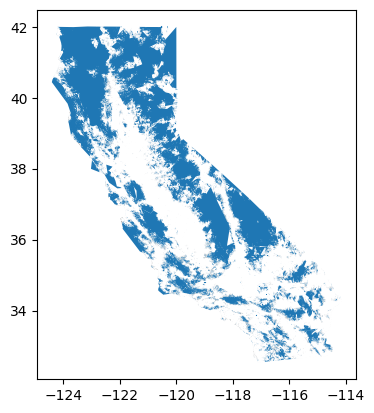

In [10]:
att2.plot()

### Load in Routes 

In [11]:
unique_routes = utilities.load_unique_routes_df()

In [12]:
unique_routes.geometry.is_valid.all()

True

In [13]:
# Ensure CRS are the same
unique_routes = unique_routes.to_crs(att2.crs)

In [14]:
unique_routes.crs == att2.crs 

True

In [15]:
# B/c route names and route ids can be the same across different agencies,
# Add these 3 different columns so the route will have a unique identifier.
# Just in case I want to loop through everything
unique_routes['long_route_name'] = unique_routes['route_name'] + unique_routes['route_id'] + ' '  + ' ' + unique_routes['agency']

In [16]:
unique_routes.long_route_name.nunique() == len(unique_routes) 

True

In [17]:
# Split this large dataframe into a few
# https://stackoverflow.com/questions/17315737/split-a-large-pandas-dataframe
df_split = np.array_split(unique_routes, 20)

In [18]:
# Grab split out df for testing 
unique_routes5 = df_split[4]

In [19]:
# Checks
unique_routes1.crs == att2.crs, len(unique_routes1), type(unique_routes1)

(True, 566, geopandas.geodataframe.GeoDataFrame)

#### Testing with certain routes - Help! 
* Chose routes that gave me issues the first time around
* Getting an error when using the `att2` gdf which simplifies geometry.
    * `TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003`
    *  Works fine with original att df.

In [20]:
# Routes from analysis v1 that didn't make sense
routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Long Beach/San Pedro"
]

In [21]:
unique_routes_subset = unique_routes[unique_routes["route_name"].isin(routes_wanted)]

In [22]:
len(unique_routes_subset)

22

In [23]:
unique_routes_subset.geometry.is_valid.all()

True

In [24]:
unique_routes_subset.crs == att2.crs

True

In [25]:
# Testing with original AT&T dataframe without simplifying geometry
intersect_subset1 = gpd.overlay(unique_routes_subset, att, how="intersection")

In [26]:
intersect_subset1

,itp_id,route_id,route_name,agency,original_route_length,long_route_name,geometry
0,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation ...,56918.543438,Oakland - San Francisco705-240 Golden Gate Br...,"MULTILINESTRING ((-122.32825 37.82216, -122.32..."
1,183,870,Long Beach/San Pedro,Los Angeles Department of Transportation,45275.955178,Long Beach/San Pedro870 Los Angeles Departmen...,"LINESTRING (-118.22198 33.76428, -118.22279 33..."
2,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.128572,Mammoth Lakes HWY 120E/395582 Yosemite Area R...,"MULTILINESTRING ((-119.62221 37.72721, -119.62..."


In [27]:
# Doesn't work with geometry simplify?
intersect_subset2 = gpd.overlay(unique_routes_subset, att2, how="intersection")

GEOSException: TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003

#### Test some of randomly sampled routes in a loop
* Using a sample of `unique_routes`
* Error trying to intersect  `att2` with various routes

In [38]:
unique_routes_sample = unique_routes.sample(10).reset_index()

In [39]:
unique_routes_sample.shape

(10, 8)

In [40]:
# Grab unique long route names for entire routes_df into a list
unique_routes_names_list = unique_routes_sample.long_route_name.unique().tolist()

<AxesSubplot:>

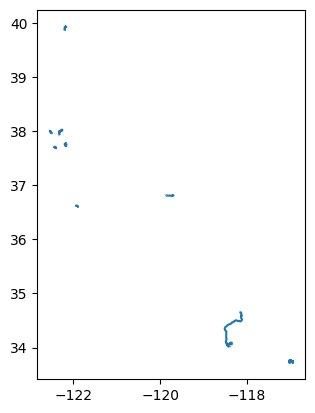

In [42]:
unique_routes_sample.plot()

In [34]:
# Empty dataframe to hold each district after clipping
all_intersected_routes = pd.DataFrame()

In [43]:
# Test with subsetted unique routes
for i in unique_routes_names_list:
    unique_routes_filtered  = unique_routes_sample[unique_routes_sample.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersected = gpd.overlay(unique_routes_filtered, att, how="intersection")
    all_intersected_routes = pd.concat([all_intersected_routes, intersected], axis=0)
    print(f"Done intersecting & concatting for {i}")

Done intersecting & concatting for Seminary - Sobrante Park45  AC Transit
Done intersecting & concatting for Asilomar-Monterey001  Monterey-Salinas Transit
Done intersecting & concatting for None786  Antelope Valley Transit Authority
Done intersecting & concatting for Hemet Valley Mall - Sanderson- East Hemet33  Riverside Transit Agency
Done intersecting & concatting for Downtown Corning & Rolling Hills143  Susanville Indian Rancheria Public Transportation Program
Done intersecting & concatting for SHAW3410  Fresno Area Express
Done intersecting & concatting for Culver City Sta - UCLA3518  Big Blue Bus
Done intersecting & concatting for Hercules Transit Center - Pinole - Richmond - BART2689  WestCAT
Done intersecting & concatting for Lipman School - Templeton/Brunswick29  SamTrans
Done intersecting & concatting for via Civic Center1394  Marin Transit


In [46]:
all_intersected_routes

,itp_id,route_id,route_name,agency,original_route_length,long_route_name,geometry,index
0,295,791,Warner Center,Santa Clarita Transit,188960.320964,Warner Center791 Santa Clarita Transit,"LINESTRING (-118.51439 34.27788, -118.51530 34...",NaN
0,295,792,Century City,Santa Clarita Transit,202275.156721,Century City792 Santa Clarita Transit,"MULTILINESTRING ((-118.47417 34.08264, -118.47...",NaN
0,295,796,Warner Center,Santa Clarita Transit,175856.393555,Warner Center796 Santa Clarita Transit,"LINESTRING (-118.57623 34.27341, -118.57611 34...",NaN
0,16,786,None,Antelope Valley Transit Authority,433489.790632,None786 Antelope Valley Transit Authority,"MULTILINESTRING ((-118.45687 34.07473, -118.45...",207.0


In [47]:
# Empty dataframe to hold each district after clipping
all_intersected_routes2 = pd.DataFrame()

#### Test a big chunk of routes dataframe - HELP!
* I get an error for certain routes even when intersecting with the original AT&T map
* This didn't happen in my `analysis_v1` so not sure why there's issues now?


In [59]:
unique_routes_subset = unique_routes.sample(100).reset_index(drop = True)

In [60]:
# Grab unique long route names for entire routes_df into a list
unique_routes_100_list = unique_routes_subset.long_route_name.unique().tolist()

In [61]:
len(unique_routes_100_list)

100

In [65]:
unique_routes_subset.geometry.is_valid.all()

True

In [62]:
# Empty dataframe to hold results
all_intersected_routes2 = pd.DataFrame()

In [63]:
for i in unique_routes_100_list:
    unique_routes_filtered  = unique_routes_subset[unique_routes_subset.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersect = gpd.overlay(unique_routes_filtered, att, how="intersection")
    all_intersected_routes2 = pd.concat([all_intersected_routes2, intersect], axis=0)
    print(f"Done intersecting & concatting for {i}")

Done intersecting & concatting for Hastings17  SolanoExpress
Done intersecting & concatting for Seven Hills, Whipple Rd, Calaveras Landing, Union Landing, Continues as Route 3 to Tropics and Union City BART4  Union City Transit
Done intersecting & concatting for The Link - Willowbrook B13315  the Link Florence-Firestone/Walnut Park
Done intersecting & concatting for PCH / SEAL BEACH171  Long Beach Transit
Done intersecting & concatting for Great America ACE Station -  South Sunnyvale822  Santa Clara Valley Transportation Authority
Done intersecting & concatting for Midtown576  Los Angeles Department of Transportation
Done intersecting & concatting for Mission Viejo - Laguna Niguel via Marguerite/Crown Valley85  Irvine Shuttle
Done intersecting & concatting for Monterey - Salinas020  Monterey-Salinas Transit
Done intersecting & concatting for Route 20 Smith River / Arcata120  Redwood Coast Transit
Done intersecting & concatting for PASADENA VIA DEL MAR STA -COLORADO-ALLEN-NEW YORK686-13

GEOSException: TopologyException: side location conflict at -117.59019600000001 33.691434999999998. This can occur if the input geometry is invalid.